In this exercise, we will adpot the UNet in Ex1 for Super Resolution problem

# Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torcheval.metrics.functional import peak_signal_noise_ratio

# Data

## Download

The data is downloaded manually on Kaggle https://www.kaggle.com/datasets/adityachandrasekhar/image-super-resolution?resource=download

In [2]:
current_path = os.getcwd()

print("Current working directory: {0}".format(current_path))

Current working directory: c:\Learning\AIO\AIO24\Module7\DomainConversion


In [3]:
from zipfile import ZipFile

# Unzip the data
with ZipFile(os.path.join(current_path, 'ImageSuperResolution.zip'), 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
LOW_IMG_SIZE = 64
HIGH_IMG_SIZE = 256

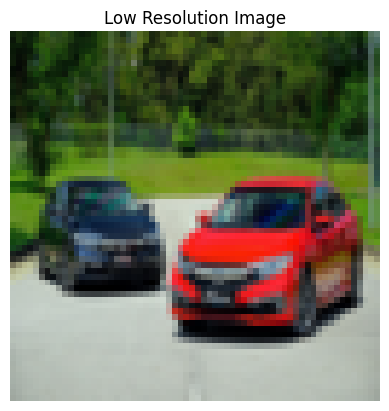

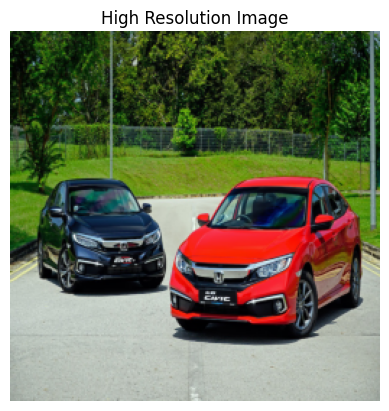

Low Resolution Image Shape: (64, 64, 4)
High Resolution Image Shape: (256, 256, 4)


In [4]:
low_res = os.path.join(current_path, 'dataset/train/low_res/0.png')
high_res = os.path.join(current_path, 'dataset/train/high_res/0.png')


low_res_img = np.array(Image.open(low_res).resize((LOW_IMG_SIZE, LOW_IMG_SIZE))).astype(np.int32)
high_res_img = np.array(Image.open(high_res).resize((HIGH_IMG_SIZE, HIGH_IMG_SIZE))).astype(np.int32)
plt.imshow(low_res_img)
plt.title('Low Resolution Image')
plt.axis('off')
plt.show()

plt.imshow(high_res_img)
plt.title('High Resolution Image')
plt.axis('off')
plt.show()

print(f'Low Resolution Image Shape: {low_res_img.shape}')
print(f'High Resolution Image Shape: {high_res_img.shape}')

## Create Pytorch Dataset

In [7]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.img_dir = img_dir
        self.is_train = is_train
        self.input_images = os.listdir(os.path.join(img_dir, 'low_res'))
        self.target_images = os.listdir(os.path.join(img_dir, 'high_res'))

    def __len__(self):
        return len(self.input_images)

    def normalize(self, image):
        image = image * 2 - 1
        return image
    
    def random_jitter ( self , input_image , target_image ) :
        if torch.rand ([]) < 0.5:
            input_image = transforms . functional . hflip ( input_image )
            target_image = transforms . functional . hflip ( target_image )

        return input_image , target_image
    
    def __getitem__(self, idx):
        input_path = os.path.join(self.img_dir, 'low_res', self.input_images[idx])
        target_path = os.path.join(self.img_dir, 'high_res', self.target_images[idx])
        
        input_image = np.array(Image.open(input_path).convert("RGB"))
        target_image = np.array(Image.open(target_path).convert("RGB"))
        input_image = transforms.ToTensor()(input_image).type(torch.float32)
        target_image = transforms.ToTensor()(target_image).type(torch.float32)

        input_image = self.normalize(input_image)
        target_image = self.normalize(target_image)
    

        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)
        
        return input_image, target_image

In [8]:
train_dataset = ImageDataset(os.path.join(current_path, 'dataset/train'), is_train = True)
val_dataset = ImageDataset(os.path.join(current_path, 'dataset/val'), is_train= False)

## Pytorch Dataloader

In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modeling

In [10]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3
    ):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_IMG_SIZE*4, LOW_IMG_SIZE*4),
                                             antialias=True)
        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)


    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x1 = self.in_conv2(x)

        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)

        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)

        x = self.out_conv(x)
        return x

# Training function

In [11]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0,
                log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(predictions, labels)
        total_count += 1
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| psnr {:8.3f}".format(
                    epoch, idx, len(train_loader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [12]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())


            total_psnr +=  peak_signal_noise_ratio(predictions, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [13]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    for epoch in range(1, num_epochs+1):
        # Training
        train_psnr, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_psnrs.append(train_psnr.cpu())
        train_losses.append(train_loss)

        # Evaluation
        eval_psnr, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_psnrs.append(eval_psnr.cpu())
        eval_losses.append(eval_loss)

        # Save best model
        if best_psnr_eval < eval_psnr :
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            best_psnr_eval = eval_psnr
        # Print loss, psnr end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
    }
    return model, metrics

# Train model and evaluate

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet(n_channels=3, n_classes=3).to(device)

lr = 1e-3
optimizer = optim.Adam(unet.parameters(), lr=lr)
criterion = nn.L1Loss()

num_epochs = 75
model_name = 'super_resolution'
save_model = os.path.join(current_path, 'models')
if not os.path.exists(save_model):
    os.makedirs(save_model)

device

device(type='cuda')

In [17]:
model, metrics = train(unet, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device)

-----------------------------------------------------------
| End of epoch   1 | Train psnr   20.248 | Train Loss    0.156 | Valid psnr   19.173 | Valid Loss    0.138 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Train psnr   22.935 | Train Loss    0.101 | Valid psnr   21.508 | Valid Loss    0.115 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Train psnr   23.780 | Train Loss    0.093 | Valid psnr   24.133 | Valid Loss    0.086 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Train psnr   24.653 | Train Loss    0.083 | Valid psnr   24.352 | Valid Loss    0.081 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Train p

## Visualize

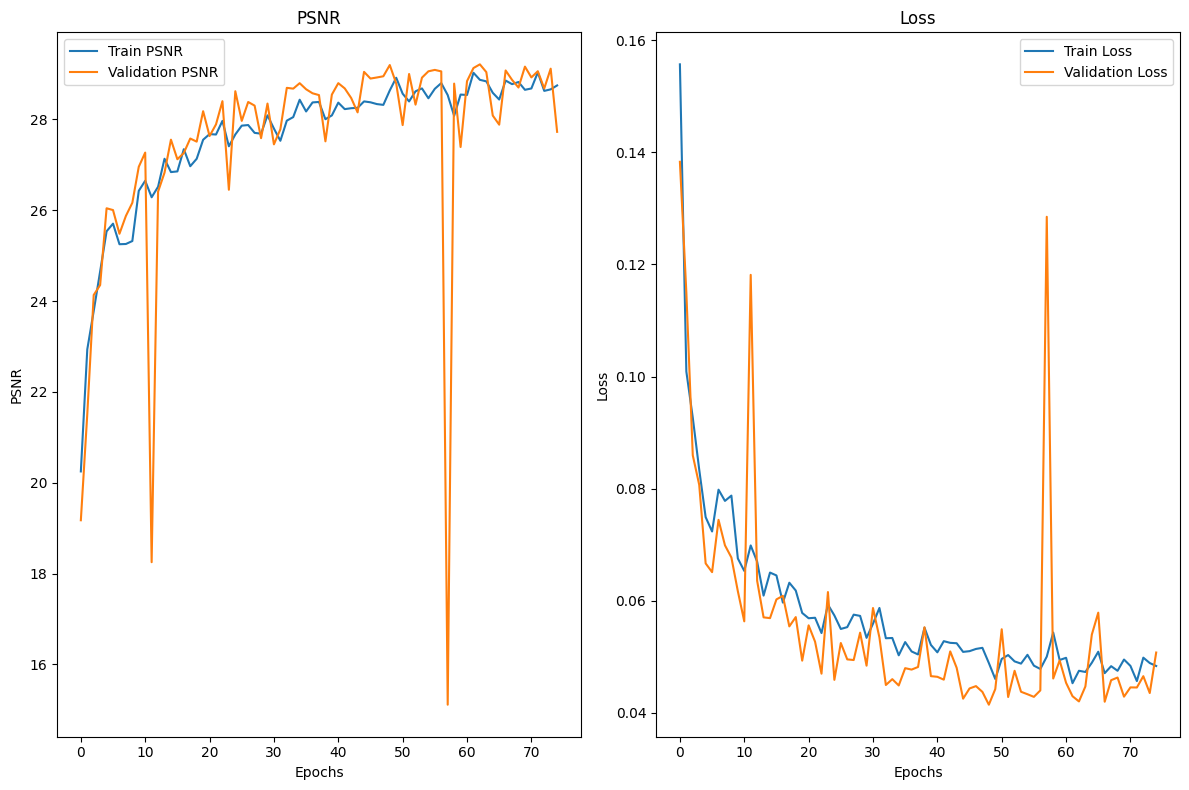

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].plot(metrics['train_psnr'], label='Train PSNR')
ax[0].plot(metrics['valid_psnr'], label='Validation PSNR')
ax[0].set_title('PSNR')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('PSNR')
ax[0].legend()
ax[1].plot(metrics['train_loss'], label='Train Loss')
ax[1].plot(metrics['valid_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.tight_layout()
plt.show()






## Inference

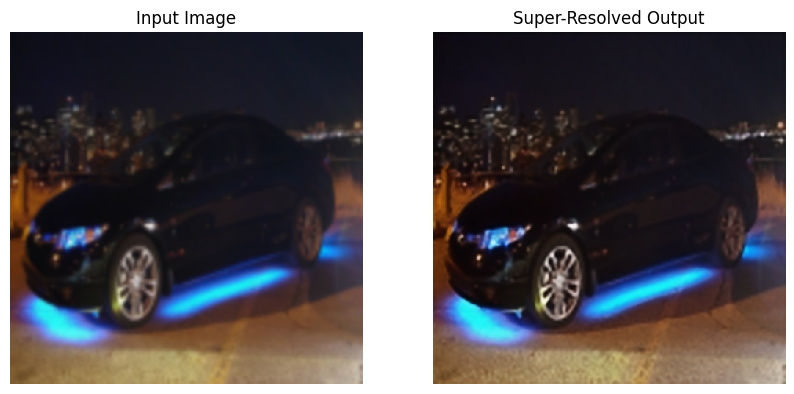

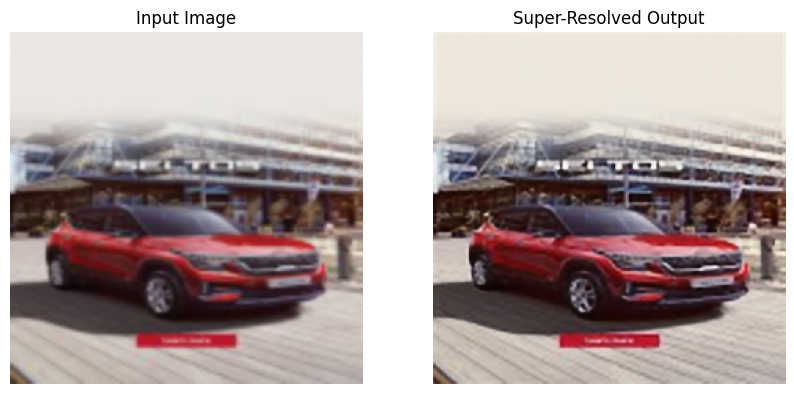

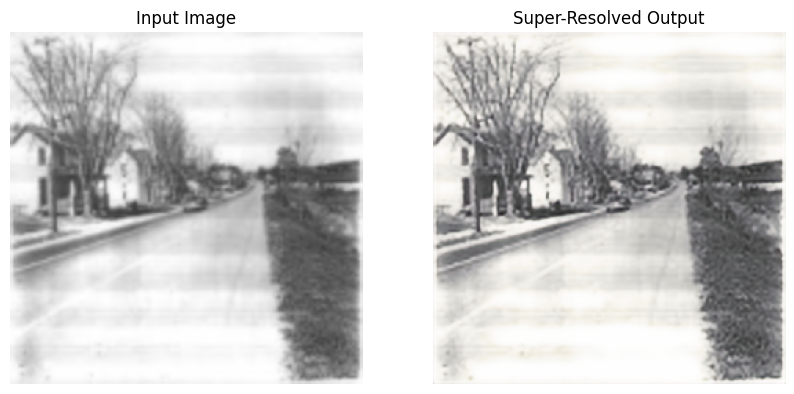

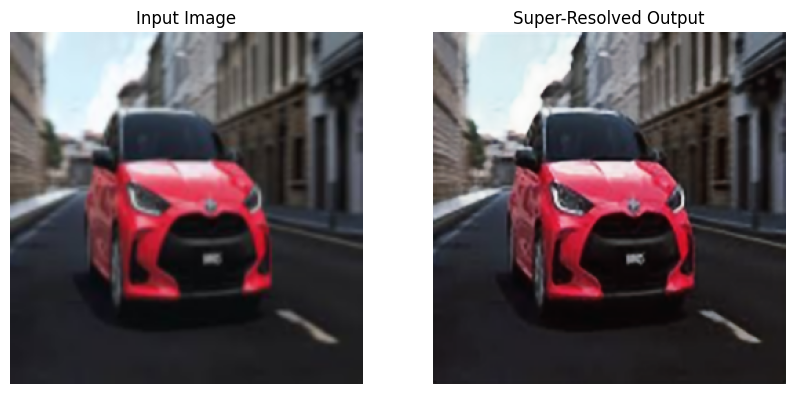

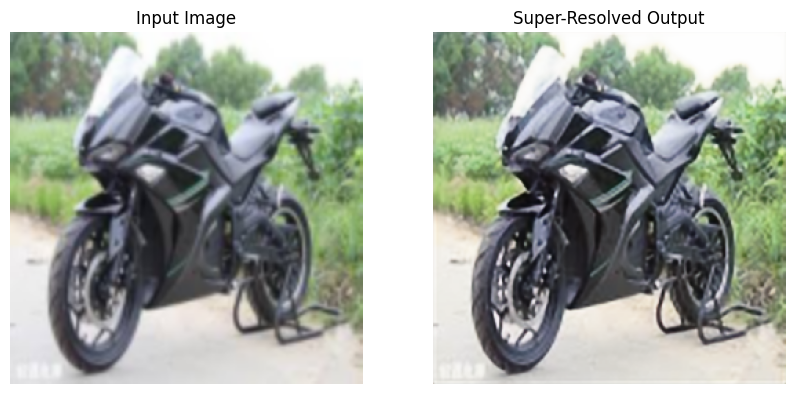

In [23]:
imgs = os.listdir(os.path.join(current_path, 'dataset/val/low_res'))
model = UNet(n_channels=3, n_classes=3).to(device)
model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
model.eval()

# Process and display the first 5 images
for img in imgs[:5]:
    input_path = os.path.join(current_path, "dataset/val/low_res", img)
    input_image = Image.open(input_path).convert("RGB")
    input_tensor = np.array(input_image)
    input_tensor = transforms.ToTensor()(input_tensor).type(torch.float32)
    # Apply transformations
    input_tensor = 2 * input_tensor - 1  # Normalize to [-1, 1]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        output = model(input_tensor)
    output = output.cpu().squeeze(0).detach().numpy().transpose(1, 2, 0)
    output = Image.fromarray(((output + 1) * 127.5).astype(np.uint8))
    
    # Post-process the output


    #output_image = transforms.ToPILImage()(output)  # Convert tensor to PIL image

    # Denormalize the input tensor before displaying
    #input_tensor = denormalize(input_tensor)  # Fix colors

    # Display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(output)
    axes[1].set_title("Super-Resolved Output")
    axes[1].axis("off")

    plt.show()